In [37]:
'''
compare two implementations of price oracle:
    arithmetic mean used by uniswap v2
    geometric mean used by uniswap v3
'''

from functools import reduce
import math
import pandas as pd
import numpy as np


In [38]:
# tick index is log(price, 1.0001)
LOG_BASE = 1.0001
time_index = [0,1,3,6,9,11,12,13,16,20,22,24,26,28,32,36]
# 5th and 11th prices are abnormal
origin_prices = [100,130,110,120,30,110,100,120,110,120,200,90,80,100,120,150]

# delta time of every besides price
# first element is 0s
delta_times = [0]
for i in range(1, len(time_index)):
    delta_times.append(time_index[i] - time_index[i-1])
    

In [39]:
# uniswap V2 use arithmetic sum
def arithmetic_sums_calc(begin, end):
    sums = []
    for i in range(begin, end):
        if i == 0:
            sums.append(origin_prices[0])
        else:
            # sum = current_price * delta time
            sums.append(origin_prices[begin+i] * delta_times[begin+i])
    return sums

# uniswap V3 use geometric sum
def geometric_sums_calc(begin, end):
    sums = []
    for i in range(begin, end):
        if i == 0:
            sums.append(math.log(origin_prices[0], LOG_BASE))
        else:
            # sum = current_price * delta time
            sums.append(math.log(origin_prices[begin+i], LOG_BASE) * delta_times[begin+i])
    return sums

arithmetic_sums = arithmetic_sums_calc(0, len(origin_prices))
geometric_sums = geometric_sums_calc(0, len(origin_prices))

print(arithmetic_sums)
print(geometric_sums)

[100, 130, 220, 360, 90, 220, 100, 120, 330, 480, 400, 180, 160, 200, 480, 600]
[46054.00440660449, 48677.77823122565, 94014.30771788706, 143631.93340141006, 102041.0231609227, 94014.30771788706, 46054.00440660449, 47877.311133803356, 141021.4615768306, 191509.24453521342, 105971.64556003807, 90000.69314129246, 87644.91464709182, 92108.00881320897, 191509.24453521342, 200435.43286744767]


In [40]:
# the cumulative price store in oracle
cumulative_arithmetic = []
cumulative_geometric = []

for i in range(1,len(origin_prices)+1):
    cumulative_arithmetic.append(reduce(lambda x,y: x+y, arithmetic_sums[0:i]))
    cumulative_geometric.append(reduce(lambda x,y: x+y, geometric_sums[0:i]))

print(cumulative_arithmetic)
print(cumulative_geometric)


[100, 230, 450, 810, 900, 1120, 1220, 1340, 1670, 2150, 2550, 2730, 2890, 3090, 3570, 4170]
[46054.00440660449, 94731.78263783014, 188746.0903557172, 332378.02375712723, 434419.0469180499, 528433.354635937, 574487.3590425415, 622364.6701763448, 763386.1317531754, 954895.3762883889, 1060867.021848427, 1150867.7149897194, 1238512.6296368113, 1330620.6384500202, 1522129.8829852336, 1722565.3158526812]


In [41]:
# calc price with oracle's cumulative price
def calc_arithmetic_oracleprice(begin,end):
    return (cumulative_arithmetic[end] - cumulative_arithmetic[begin]) / (time_index[end] - time_index[begin])

def calc_geometric_oracleprice(begin,end):
    return math.pow(LOG_BASE, (cumulative_geometric[end] - cumulative_geometric[begin]) / (time_index[end] - time_index[begin]))

WINDOW_SIZE = 4

np_mean_prices = []
oracle_arithmetic_prices = []
oracle_geometric_prices = []

for i in range(0,len(origin_prices)):
    if i < WINDOW_SIZE:
        np_mean_prices.append(None)
        oracle_arithmetic_prices.append(None)
        oracle_geometric_prices.append(None)
    else:
        np_mean_prices.append(np.mean(origin_prices[i-WINDOW_SIZE:i]))
        oracle_arithmetic_prices.append(calc_arithmetic_oracleprice(i-WINDOW_SIZE,i))
        oracle_geometric_prices.append(calc_geometric_oracleprice(i-WINDOW_SIZE,i))

df = pd.DataFrame({
  'time_index': time_index,
  'price': origin_prices,
  'delta_times': delta_times,
  'cumulative_arithmetic': cumulative_arithmetic,
  'cumulative_geometric': cumulative_geometric,
  'oracle_arithmetic_prices': oracle_arithmetic_prices,
  'oracle_geometric_prices': oracle_geometric_prices,
})

# the result showing arithmetic mean giving higher price more weight
# and geometric mean giving lower price more weight
print(df)


    time_index  price  delta_times  cumulative_arithmetic  \
0            0    100            0                    100   
1            1    130            1                    230   
2            3    110            2                    450   
3            6    120            3                    810   
4            9     30            3                    900   
5           11    110            2                   1120   
6           12    100            1                   1220   
7           13    120            1                   1340   
8           16    110            3                   1670   
9           20    120            4                   2150   
10          22    200            2                   2550   
11          24     90            2                   2730   
12          26     80            2                   2890   
13          28    100            2                   3090   
14          32    120            4                   3570   
15          36    150   

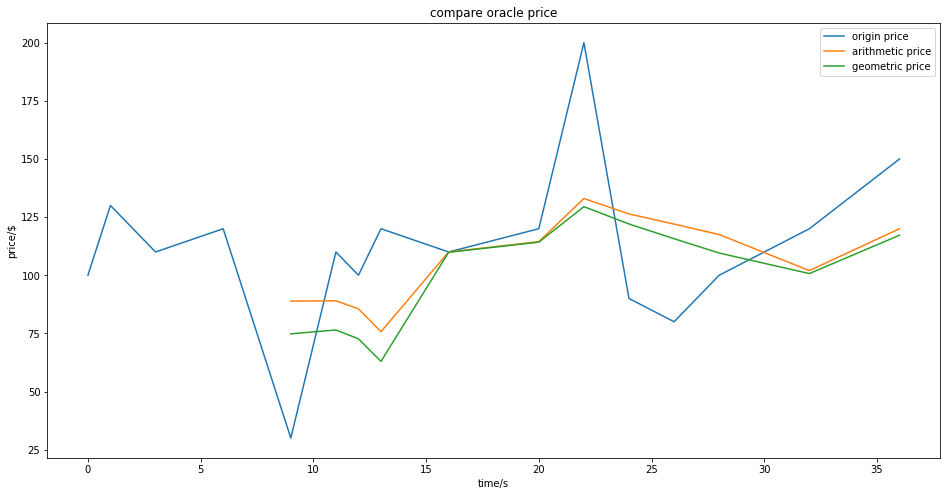

In [42]:
'''
arithmetic mean is more stable than geometric mean.
time 12s 
'''
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.plot(time_index, origin_prices, label="origin price")
plt.plot(time_index, oracle_arithmetic_prices, label="arithmetic price")
plt.plot(time_index, oracle_geometric_prices, label="geometric price")
plt.legend()
plt.xlabel('time/s')
plt.ylabel('price/$')
plt.title('compare oracle price')
plt.show()